In [1]:
import numpy as np
#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf

import copy

# Prepare Data

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [3]:
print(x_train.shape)

C = np.max(y_train)+1
print(C)

(60000, 28, 28)
10


In [4]:
# normalize images to [0, 1]
x_train_unnorm = x_train
x_test_unnorm = x_test

x_all = np.concatenate((x_train, x_test), axis=0)
x_train = x_train / np.amax(x_all)
x_test = x_test / np.amax(x_all)

In [5]:
# flatten
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1]*x_train.shape[2])
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1]*x_test.shape[2])

x_train_unnorm = x_train_unnorm.reshape(x_train_unnorm.shape[0], x_train_unnorm.shape[1]*x_train_unnorm.shape[2])
x_test_unnorm = x_test_unnorm.reshape(x_test_unnorm.shape[0], x_test_unnorm.shape[1]*x_test_unnorm.shape[2])

print(x_train.shape)

(60000, 784)


In [6]:
# add bias
x_train = np.c_[x_train, np.ones(x_train.shape[0])]
x_test = np.c_[x_test, np.ones(x_test.shape[0])]

x_train_unnorm = np.c_[x_train_unnorm, np.ones(x_train_unnorm.shape[0])]
x_test_unnorm = np.c_[x_test_unnorm, np.ones(x_test_unnorm.shape[0])]

print(x_train.shape)

(60000, 785)


# Function and Class Definitions

## Accuracy / Error Function

In [7]:
# Calculate accuracy
evaluate_acc = lambda y_test, y_pred: np.sum(y_test == y_pred)/y_test.shape[0]*100
evaluate_err = lambda y_test, y_pred: (1-np.sum(y_test == y_pred)/y_test.shape[0])*100

## One-Hot Encoding

In [8]:
def onehot(y):
    N = y.shape[0]
    C = np.max(y)+1
    yc = np.zeros((N,C))
    for i in range(N):
        yc[i, y[i]] = 1
    return yc.astype(int)

def decode(yc):
    return np.argmax(yc, axis=1)


## Activation Functions

In [9]:
logistic = lambda z: 1./ (1 + np.exp(-z))
ReLU = lambda z: np.maximum(0,z)
tanh = lambda z: np.tanh(z)
leakyReLU = lambda z: np.maximum(0,z) + 0.01 * np.minimum(0,z)

# wrapper for running functions passed in as argument
def apply(fun, z):
    return fun(z)

# derivative of ReLU
dReLU = lambda z: np.heaviside(z, 0)

# derivative of tanh
dtanh = lambda z: 1 - np.square(np.tanh(z))

# derivative of leakyReLU
dleakyReLU = lambda z: np.heaviside(z, 0) + (1 - np.heaviside(z, 1)) * 0.01

def softmax(z):
    # N x C
    z -= np.amax(z, axis=1)[:, None]    # prevent overflow
    return np.exp(z) / np.sum(np.exp(z), axis=1)[:, None]


# Multi-Layer Perceptron

## (1) MLP with no hidden layers

In [10]:
class MLP_None:
    # No hidden layer
    
    def __init__(self, record_history=False):
        # no hidden layers and no activation functions
        self.record_history = record_history
    
    def fit(self, x, y, optimizer):
        N,D = x.shape
        y = onehot(y)
        C = y.shape[1]
        def gradient(x, y, params):
            # W is C x D
            W = params[0]
            yh = softmax(np.matmul(x, W.T))         #N x C
            # using softmax cross-entropy loss
            dy = yh - y                             #N x C
            dW = np.matmul(dy.T, x)                 #C x D
            dparams = [dW]
            return dparams

        # initialize weights to random numbers N(0, 1) * .01
        W0 = np.random.randn(C,D) * .01
        params0 = [W0]
        self.params = optimizer.run(gradient, x, y, params0)
        return self
    
    def predict(self, x):
        W = self.params[0]
        yh = softmax(np.matmul(x, W.T))             #N x C
        return decode(yh)                           #N

## (2) MLP with one fully connected layer, ReLU

In [11]:
class MLP_One_ReLU:
    # One hidden layer, ReLU activation function 
    
    def __init__(self, M = 128):
        # by default: 128 hidden units
        self.M = M
            
    def fit(self, x, y, optimizer):
        N,D = x.shape
        y = onehot(y)
        C = y.shape[1]
        def gradient(x, y, params):
            V, W = params
            # V is M x D, W is C x M
            q = np.matmul(x, V.T)                 #N x M
            z = ReLU(q)                           #N x M
            yh = softmax(np.matmul(z, W.T))       #N x C
            dy = yh - y                           #N x C
            dW = np.matmul(dy.T, z)               #C x M
            dz = np.matmul(dy, W)                 #N x M
            dV = np.matmul((dz * dReLU(q)).T, x)  #M x D
            dparams = [dV, dW]
            return dparams
        
        # initialize weights to random numbers N(0, 1) * .01
        W0 = np.random.randn(C, self.M) * .01
        V0 = np.random.randn(self.M, D) * .01
        params0 = [V0, W0]
        self.params = optimizer.run(gradient, x, y, params0)
        return self
    
    def predict(self, x):
        V, W = self.params
        z = ReLU(np.matmul(x, V.T))               #N x M
        yh = softmax(np.matmul(z, W.T))           #N x C
        return decode(yh)                         #N

## (3) MLP with two fully connected layers, ReLU

In [12]:
class MLP_Two_ReLU:
    # Two hidden layers, ReLU activation function 
    
    def __init__(self, M = 128, O = 128):
        # by default: 128 hidden units
        self.M = M
        self.O = O
            
    def fit(self, x, y, optimizer):
        N,D = x.shape
        y = onehot(y)
        C = y.shape[1]
        def gradient(x, y, params):
            U, V, W = params
            #  U is M X D, V is O x M, W is C x O
            r = np.matmul(x, U.T)                 #N X M
            s = ReLU(r)                           #N X M
            q = np.matmul(s, V.T)                 #N x O
            z = ReLU(q)                           #N x O
            yh = softmax(np.matmul(z, W.T))       #N x C
            dy = yh - y                           #N x C
            dW = np.matmul(dy.T, z)               #C x O
            dz = np.matmul(dy, W)                 #N x O
            dV = np.matmul((dz * dReLU(q)).T, s)  #O x M
            ds = np.matmul(dz, V)                 #N X M
            dU = np.matmul((ds * dReLU(r)).T, x)  #M X D
            dparams = [dU, dV, dW]
            return dparams
        
        # initialize weights to random numbers N(0, 1) * .01
        W0 = np.random.randn(C, self.O) * .01
        V0 = np.random.randn(self.O, self.M) * .01
        U0 = np.random.randn(self.M, D) * .01
        params0 = [U0, V0, W0]
        self.params = optimizer.run(gradient, x, y, params0)
        return self
    
    def predict(self, x):
        U, V, W = self.params
        s = ReLU(np.matmul(x, U.T))               #N X M
        z = ReLU(np.matmul(s, V.T))               #N X O
        yh = softmax(np.matmul(z, W.T))           #N x C
        return decode(yh)                         #N

## (4) MLP with two fully connected layers, tanh

In [13]:
class MLP_Two_tanh:
    # Two hidden layers, tanh activation function 
    
    def __init__(self, M = 128, O = 128):
        # by default: 128 hidden units
        self.M = M
        self.O = O
            
    def fit(self, x, y, optimizer):
        N,D = x.shape
        y = onehot(y)
        C = y.shape[1]
        def gradient(x, y, params):
            U, V, W = params
            #  U is M X D, V is O x M, W is C x O
            r = np.matmul(x, U.T)                 #N X M
            s = tanh(r)                           #N X M
            q = np.matmul(s, V.T)                 #N x O
            z = tanh(q)                           #N x O
            yh = softmax(np.matmul(z, W.T))       #N x C
            dy = yh - y                           #N x C
            dW = np.matmul(dy.T, z)               #C x O
            dz = np.matmul(dy, W)                 #N x O
            dV = np.matmul((dz * dtanh(q)).T, s)  #O x M
            ds = np.matmul(dz, V)                 #N X M
            dU = np.matmul((ds * dtanh(r)).T, x)  #M X D
            dparams = [dU, dV, dW]
            return dparams
        
        # initialize weights to random numbers N(0, 1) * .01
        W0 = np.random.randn(C, self.O) * .01
        V0 = np.random.randn(self.O, self.M) * .01
        U0 = np.random.randn(self.M, D) * .01
        params0 = [U0, V0, W0]
        self.params = optimizer.run(gradient, x, y, params0)
        return self
    
    def predict(self, x):
        U, V, W = self.params
        s = tanh(np.matmul(x, U.T))               #N X M
        z = tanh(np.matmul(s, V.T))               #N X O
        yh = softmax(np.matmul(z, W.T))           #N x C
        return decode(yh)                         #N

## (5) MLP with two fully connected layers, leaky ReLU

In [14]:
class MLP_Two_leakyReLU:
    # Two hidden layers, leaky ReLU activation function 
    
    def __init__(self, M = 128, O = 128):
        # by default: 128 hidden units
        self.M = M
        self.O = O
            
    def fit(self, x, y, optimizer):
        N,D = x.shape
        y = onehot(y)
        C = y.shape[1]
        def gradient(x, y, params):
            U, V, W = params
            #  U is M X D, V is O x M, W is C x O
            r = np.matmul(x, U.T)                 #N X M
            s = leakyReLU(r)                      #N X M
            q = np.matmul(s, V.T)                 #N x O
            z = leakyReLU(q)                      #N x O
            yh = softmax(np.matmul(z, W.T))       #N x C
            dy = yh - y                           #N x C
            dW = np.matmul(dy.T, z)               #C x O
            dz = np.matmul(dy, W)                 #N x O
            dV = np.matmul((dz * dleakyReLU(q)).T, s)  #O x M
            ds = np.matmul(dz, V)                      #N X M
            dU = np.matmul((ds * dleakyReLU(r)).T, x)  #M X D
            dparams = [dU, dV, dW]
            return dparams
        
        # initialize weights to random numbers N(0, 1) * .01
        W0 = np.random.randn(C, self.O) * .01
        V0 = np.random.randn(self.O, self.M) * .01
        U0 = np.random.randn(self.M, D) * .01
        params0 = [U0, V0, W0]
        self.params = optimizer.run(gradient, x, y, params0)
        return self
    
    def predict(self, x):
        U, V, W = self.params
        s = leakyReLU(np.matmul(x, U.T))          #N X M
        z = leakyReLU(np.matmul(s, V.T))          #N X O
        yh = softmax(np.matmul(z, W.T))           #N x C
        return decode(yh)                         #N

## (6) MLP with two fully connected layers with dropout regularization, ReLU

In [15]:
class MLP_Two_ReLU_Drop:
    # Two hidden layers, ReLU activation function, dropout regularization
    
    def __init__(self, M = 128, O = 128, keep_rate = 0.8):
        # by default: 128 hidden units
        self.M = M
        self.O = O
        self.keep_rate = keep_rate
            
    def fit(self, x, y, optimizer):
        N,D = x.shape
        y = onehot(y)
        C = y.shape[1]
        def gradient(x, y, params):     
            U, V, W = params
            # V is O x M, W is C x O, U is M X D
            r = np.matmul(x, U.T)                 #N X M
            s = ReLU(r)                           #N X M
            dr = np.random.rand(s.shape[0],s.shape[1]) #add dropout in at the first layer.
            dr = dr < self.keep_rate
            s_d = s * dr
            s_d = (s_d)/self.keep_rate
            q = np.matmul(s_d, V.T)               #N x O
            z = ReLU(q)                           #N x O
            yh = softmax(np.matmul(z, W.T))       #N x C
            dy = yh - y                           #N x C
            dW = np.matmul(dy.T, z)               #C x O
            dz = np.matmul(dy, W)                 #N x O
            dV = np.matmul((dz * dReLU(q)).T, s_d)  #O x M
            ds = np.matmul(dz, V)                 #N X M
            dU = np.matmul((ds * dReLU(r)).T, x)  #M X D
            dparams = [dU, dV, dW]
            return dparams
        
        # initialize weights to random numbers N(0, 1) * .01
        W0 = np.random.randn(C, self.O) * .01
        V0 = np.random.randn(self.O, self.M) * .01
        U0 = np.random.randn(self.M, D) * .01
        params0 = [U0, V0, W0]
        self.params = optimizer.run(gradient, x, y, params0)
        return self
    
    def predict(self, x):
        U, V, W = self.params
        s = ReLU(np.matmul(x, U.T))               #N X M
        z = ReLU(np.matmul(s, V.T))               #N X O
        yh = softmax(np.matmul(z, W.T))           #N x C
        return decode(yh)                         #N

## (7) MLP with two fully connected layers with dropout regularization, tanh

In [16]:
class MLP_Two_tanh_Drop:
    # Two hidden layers, tanh activation function, dropout regularization
    
    def __init__(self, M = 128, O = 128, keep_rate = 0.8):
        # by default: 128 hidden units
        self.M = M
        self.O = O
        self.keep_rate = keep_rate
            
    def fit(self, x, y, optimizer):
        N,D = x.shape
        y = onehot(y)
        C = y.shape[1]
        def gradient(x, y, params):     
            U, V, W = params
            # V is O x M, W is C x O, U is M X D
            r = np.matmul(x, U.T)                 #N X M
            s = tanh(r)                           #N X M
            dr = np.random.rand(s.shape[0],s.shape[1]) #add dropout in at the first layer.
            dr = dr < self.keep_rate
            s_d = s * dr
            s_d = (s_d)/self.keep_rate
            q = np.matmul(s_d, V.T)               #N x O
            z = tanh(q)                           #N x O
            yh = softmax(np.matmul(z, W.T))       #N x C
            dy = yh - y                           #N x C
            dW = np.matmul(dy.T, z)               #C x O
            dz = np.matmul(dy, W)                 #N x O
            dV = np.matmul((dz * dtanh(q)).T, s_d)  #O x M
            ds = np.matmul(dz, V)                 #N X M
            dU = np.matmul((ds * dtanh(r)).T, x)  #M X D
            dparams = [dU, dV, dW]
            return dparams
        
        # initialize weights to random numbers N(0, 1) * .01
        W0 = np.random.randn(C, self.O) * .01
        V0 = np.random.randn(self.O, self.M) * .01
        U0 = np.random.randn(self.M, D) * .01
        params0 = [U0, V0, W0]
        self.params = optimizer.run(gradient, x, y, params0)
        return self
    
    def predict(self, x):
        U, V, W = self.params
        s = tanh(np.matmul(x, U.T))               #N X M
        z = tanh(np.matmul(s, V.T))               #N X O
        yh = softmax(np.matmul(z, W.T))           #N x C
        return decode(yh)                         #N

## (8) MLP with two fully connected layers with dropout regularization, leaky ReLU

In [17]:
class MLP_Two_leakyReLU_Drop:
    # Two hidden layers, leaky ReLU activation function, dropout regularization
    
    def __init__(self, M = 128, O = 128, keep_rate = 0.8):
        # by default: 128 hidden units
        self.M = M
        self.O = O
        self.keep_rate = keep_rate
            
    def fit(self, x, y, optimizer):
        N,D = x.shape
        y = onehot(y)
        C = y.shape[1]
        def gradient(x, y, params):     
            U, V, W = params
            # V is O x M, W is C x O, U is M X D
            r = np.matmul(x, U.T)                 #N X M
            s = leakyReLU(r)                           #N X M
            dr = np.random.rand(s.shape[0],s.shape[1]) #add dropout in at the first layer.
            dr = dr < self.keep_rate
            s_d = s * dr
            s_d = (s_d)/self.keep_rate
            q = np.matmul(s_d, V.T)               #N x O
            z = leakyReLU(q)                           #N x O
            yh = softmax(np.matmul(z, W.T))       #N x C
            dy = yh - y                           #N x C
            dW = np.matmul(dy.T, z)               #C x O
            dz = np.matmul(dy, W)                 #N x O
            dV = np.matmul((dz * dleakyReLU(q)).T, s_d)  #O x M
            ds = np.matmul(dz, V)                 #N X M
            dU = np.matmul((ds * dleakyReLU(r)).T, x)  #M X D
            dparams = [dU, dV, dW]
            return dparams
        
        # initialize weights to random numbers N(0, 1) * .01
        W0 = np.random.randn(C, self.O) * .01
        V0 = np.random.randn(self.O, self.M) * .01
        U0 = np.random.randn(self.M, D) * .01
        params0 = [U0, V0, W0]
        self.params = optimizer.run(gradient, x, y, params0)
        return self
    
    def predict(self, x):
        U, V, W = self.params
        s = leakyReLU(np.matmul(x, U.T))               #N X M
        z = leakyReLU(np.matmul(s, V.T))               #N X O
        yh = softmax(np.matmul(z, W.T))           #N x C
        return decode(yh)                         #N

# Gradient Descent Implementation

## Full Batch

In [18]:
class GradientDescent:
    
    def __init__(self, learning_rate=.001, max_iters=1e4, epsilon=1e-8):
        self.learning_rate = learning_rate
        self.max_iters = max_iters
        self.epsilon = epsilon
        
    def run(self, gradient_fn, x, y, params):
        norms = np.array([np.inf])
        t = 1
        while np.any(norms > self.epsilon) and t < self.max_iters:
            grad = gradient_fn(x, y, params)
            for p in range(len(params)):
                params[p] -= self.learning_rate * grad[p]
            t += 1
            norms = np.array([np.linalg.norm(g) for g in grad])
        if t == self.max_iters:
            print("Did not converge at maximum iteration.")
            print("norms =", norms)
        return params

## Mini Batch

In [19]:
class MiniBatchGradientDescent:

    def __init__(self, learning_rate=.001, max_iters=1e4, epsilon=1e-8, batch_size=32):
        self.learning_rate = learning_rate
        self.max_iters = max_iters
        self.epsilon = epsilon
        self.batch_size = batch_size

    def run(self, gradient_fn, x, y, params):
        N = x.shape[0]
        if self.batch_size > N:   #in this case mini batch becomes full batch
            self.batch_size = N
        num_batches = N // self.batch_size

        norms = np.array([np.inf])
        t = 1
        while np.any(norms > self.epsilon) and t < self.max_iters:
            rate = self.learning_rate * (t ** (-0.51))    # decaying learning rate
            random_indices = np.random.permutation(N)
            x_tmp = x[random_indices]
            y_tmp = y[random_indices]
            for j in range(0, N, self.batch_size):
                xj = x_tmp[j:j+self.batch_size]
                yj = y_tmp[j:j+self.batch_size]
                grad = gradient_fn(xj, yj, params)
                for p in range(len(params)):
                    params[p] -= rate * grad[p]
            t += 1
            norms = np.array([np.linalg.norm(g) for g in grad])
        if t == self.max_iters:
            print("Did not converge at maximum iteration.")
            print("norms =", norms)
        return params


## Mini Batch with Adam

In [20]:
class AdamMiniBatchGradientDescent:

    def __init__(self, learning_rate=.001, max_iters=1e2, epsilon=1e-8, batch_size=32, beta1 = 0.9, beta2 = 0.99):
        self.learning_rate = learning_rate
        self.max_iters = max_iters
        self.epsilon = epsilon
        self.batch_size = batch_size
        self.beta1 = beta1
        self.beta2 = beta2

    def run(self, gradient_fn, x, y, params):
        N = x.shape[0]
        if self.batch_size > N:   #in this case mini batch becomes full batch
            self.batch_size = N

        M = np.zeros_like(params)   # initialize M and S to zeros
        S = np.zeros_like(params)
        Mh = np.zeros_like(params)
        Sh = np.zeros_like(params)

        norms = np.array([np.inf])
        t = 1
        while np.any(norms > self.epsilon) and t < self.max_iters:
            random_indices = np.random.permutation(N)
            x_tmp = x[random_indices]
            y_tmp = y[random_indices]
            for j in range(0, N, self.batch_size):
                xj = x_tmp[j:j+self.batch_size]
                yj = y_tmp[j:j+self.batch_size]
                grad = gradient_fn(xj, yj, params)
                for p in range(len(params)):
                    M[p] = self.beta1 * M[p] + (1-self.beta1) * grad[p]
                    S[p] = self.beta2 * S[p] + (1-self.beta2) * np.square(grad[p])
                    Mh[p] = M[p] / (1.0 - self.beta1**(t))
                    Sh[p] = S[p] / (1.0 - self.beta2**(t))
                    params[p] -= self.learning_rate * Mh[p] / (np.sqrt(Sh[p]) + np.finfo(float).eps)
            t += 1
            norms = np.array([np.linalg.norm(g) for g in grad])
        if t == self.max_iters:
            print("Did not converge at maximum iteration.")
            print("norms =", norms)
        return params


# Implementation with history (for loss/accuracy plots)

## Model (1) with history

In [21]:
class MLP_None_Hist:
    # No hidden layer
    
    def __init__(self):
        # no hidden layers and no activation functions
        self.norm_hist = []
        self.param_hist = []
    
    def fit(self, x, y, optimizer):
        N,D = x.shape
        y = onehot(y)
        C = y.shape[1]
        def gradient(x, y, params):
            # W is C x D
            W = params[0]
            yh = softmax(np.matmul(x, W.T))         #N x C
            # using softmax cross-entropy loss
            dy = yh - y                             #N x C
            dW = np.matmul(dy.T, x)                 #C x D
            dparams = [dW]
            return dparams

        # initialize weights to random numbers N(0, 1) * .01
        W0 = np.random.randn(C,D) * .01
        params0 = [W0]
        self.params, self.norm_hist, self.param_hist = optimizer.run(gradient, x, y, params0)
        return self
    
    def predict(self, x):
        W = self.params[0]
        yh = softmax(np.matmul(x, W.T))             #N x C
        return decode(yh)                           #N

    def check(params, x):
        W = params[0]
        yh = softmax(np.matmul(x, W.T))             #N x C
        return decode(yh)                           #N

## Model (2) with history

In [22]:
class MLP_One_ReLU_Hist:
    # One hidden layer, ReLU activation function 
    
    def __init__(self, M = 128):
        # by default: 128 hidden units
        self.M = M
        self.norm_hist = []
        self.param_hist = []
            
    def fit(self, x, y, optimizer):
        N,D = x.shape
        y = onehot(y)
        C = y.shape[1]
        def gradient(x, y, params):
            V, W = params
            # V is M x D, W is C x M
            q = np.matmul(x, V.T)                 #N x M
            z = ReLU(q)                           #N x M
            yh = softmax(np.matmul(z, W.T))       #N x C
            dy = yh - y                           #N x C
            dW = np.matmul(dy.T, z)               #C x M
            dz = np.matmul(dy, W)                 #N x M
            dV = np.matmul((dz * dReLU(q)).T, x)  #M x D
            dparams = [dV, dW]
            return dparams
        
        # initialize weights to random numbers N(0, 1) * .01
        W0 = np.random.randn(C, self.M) * .01
        V0 = np.random.randn(self.M, D) * .01
        params0 = [V0, W0]
        self.params, self.norm_hist, self.param_hist = optimizer.run(gradient, x, y, params0)
        return self
    
    def predict(self, x):
        V, W = self.params
        z = ReLU(np.matmul(x, V.T))               #N x M
        yh = softmax(np.matmul(z, W.T))           #N x C
        return decode(yh)                         #N
    
    def check(params, x):
        V, W = params
        z = ReLU(np.matmul(x, V.T))               #N x M
        yh = softmax(np.matmul(z, W.T))           #N x C
        return decode(yh)                         #N

## Model (3) with history

In [23]:
class MLP_Two_ReLU_Hist:
    # Two hidden layers, ReLU activation function 
    
    def __init__(self, M = 128, O = 128):
        # by default: 128 hidden units
        self.M = M
        self.O = O
        self.norm_hist = []
        self.param_hist = []
            
    def fit(self, x, y, optimizer):
        N,D = x.shape
        y = onehot(y)
        C = y.shape[1]
        def gradient(x, y, params):
            U, V, W = params
            #  U is M X D, V is O x M, W is C x O
            r = np.matmul(x, U.T)                 #N X M
            s = ReLU(r)                           #N X M
            q = np.matmul(s, V.T)                 #N x O
            z = ReLU(q)                           #N x O
            yh = softmax(np.matmul(z, W.T))       #N x C
            dy = yh - y                           #N x C
            dW = np.matmul(dy.T, z)               #C x O
            dz = np.matmul(dy, W)                 #N x O
            dV = np.matmul((dz * dReLU(q)).T, s)  #O x M
            ds = np.matmul(dz, V)                 #N X M
            dU = np.matmul((ds * dReLU(r)).T, x)  #M X D
            dparams = [dU, dV, dW]
            return dparams
        
        # initialize weights to random numbers N(0, 1) * .01
        W0 = np.random.randn(C, self.O) * .01
        V0 = np.random.randn(self.O, self.M) * .01
        U0 = np.random.randn(self.M, D) * .01
        params0 = [U0, V0, W0]
        self.params, self.norm_hist, self.param_hist = optimizer.run(gradient, x, y, params0)
        return self
    
    def predict(self, x):
        U, V, W = self.params
        s = ReLU(np.matmul(x, U.T))               #N X M
        z = ReLU(np.matmul(s, V.T))               #N X O
        yh = softmax(np.matmul(z, W.T))           #N x C
        return decode(yh)                         #N

    def check(params, x):
        U, V, W = params
        s = ReLU(np.matmul(x, U.T))               #N X M
        z = ReLU(np.matmul(s, V.T))               #N X O
        yh = softmax(np.matmul(z, W.T))           #N x C
        return decode(yh)                         #N

## Model (4) with history

In [24]:
class MLP_Two_tanh_Hist:
    # Two hidden layers, tanh activation function 
    
    def __init__(self, M = 128, O = 128):
        # by default: 128 hidden units
        self.M = M
        self.O = O
        self.norm_hist = []
        self.param_hist = []
            
    def fit(self, x, y, optimizer):
        N,D = x.shape
        y = onehot(y)
        C = y.shape[1]
        def gradient(x, y, params):
            U, V, W = params
            #  U is M X D, V is O x M, W is C x O
            r = np.matmul(x, U.T)                 #N X M
            s = tanh(r)                           #N X M
            q = np.matmul(s, V.T)                 #N x O
            z = tanh(q)                           #N x O
            yh = softmax(np.matmul(z, W.T))       #N x C
            dy = yh - y                           #N x C
            dW = np.matmul(dy.T, z)               #C x O
            dz = np.matmul(dy, W)                 #N x O
            dV = np.matmul((dz * dtanh(q)).T, s)  #O x M
            ds = np.matmul(dz, V)                 #N X M
            dU = np.matmul((ds * dtanh(r)).T, x)  #M X D
            dparams = [dU, dV, dW]
            return dparams
        
        # initialize weights to random numbers N(0, 1) * .01
        W0 = np.random.randn(C, self.O) * .01
        V0 = np.random.randn(self.O, self.M) * .01
        U0 = np.random.randn(self.M, D) * .01
        params0 = [U0, V0, W0]
        self.params, self.norm_hist, self.param_hist = optimizer.run(gradient, x, y, params0)
        return self
    
    def predict(self, x):
        U, V, W = self.params
        s = tanh(np.matmul(x, U.T))               #N X M
        z = tanh(np.matmul(s, V.T))               #N X O
        yh = softmax(np.matmul(z, W.T))           #N x C
        return decode(yh)                         #N

    def check(params, x):
        U, V, W = params
        s = tanh(np.matmul(x, U.T))               #N X M
        z = tanh(np.matmul(s, V.T))               #N X O
        yh = softmax(np.matmul(z, W.T))           #N x C
        return decode(yh)                         #N

## Model (5) with history

In [25]:
class MLP_Two_leakyReLU_Hist:
    # Two hidden layers, leaky ReLU activation function 
    
    def __init__(self, M = 128, O = 128):
        # by default: 128 hidden units
        self.M = M
        self.O = O
        self.norm_hist = []
        self.param_hist = []
            
    def fit(self, x, y, optimizer):
        N,D = x.shape
        y = onehot(y)
        C = y.shape[1]
        def gradient(x, y, params):
            U, V, W = params
            #  U is M X D, V is O x M, W is C x O
            r = np.matmul(x, U.T)                 #N X M
            s = leakyReLU(r)                           #N X M
            q = np.matmul(s, V.T)                 #N x O
            z = leakyReLU(q)                           #N x O
            yh = softmax(np.matmul(z, W.T))       #N x C
            dy = yh - y                           #N x C
            dW = np.matmul(dy.T, z)               #C x O
            dz = np.matmul(dy, W)                 #N x O
            dV = np.matmul((dz * dleakyReLU(q)).T, s)  #O x M
            ds = np.matmul(dz, V)                 #N X M
            dU = np.matmul((ds * dleakyReLU(r)).T, x)  #M X D
            dparams = [dU, dV, dW]
            return dparams
        
        # initialize weights to random numbers N(0, 1) * .01
        W0 = np.random.randn(C, self.O) * .01
        V0 = np.random.randn(self.O, self.M) * .01
        U0 = np.random.randn(self.M, D) * .01
        params0 = [U0, V0, W0]
        self.params, self.norm_hist, self.param_hist = optimizer.run(gradient, x, y, params0)
        return self
    
    def predict(self, x):
        U, V, W = self.params
        s = leakyReLU(np.matmul(x, U.T))               #N X M
        z = leakyReLU(np.matmul(s, V.T))               #N X O
        yh = softmax(np.matmul(z, W.T))           #N x C
        return decode(yh)                         #N

    def check(params, x):
        U, V, W = params
        s = leakyReLU(np.matmul(x, U.T))               #N X M
        z = leakyReLU(np.matmul(s, V.T))               #N X O
        yh = softmax(np.matmul(z, W.T))           #N x C
        return decode(yh)                         #N

## Model (6) with history

In [26]:
class MLP_Two_ReLU_Drop_Hist:
    # Two hidden layers, ReLU activation function, dropout regularization
    
    def __init__(self, M = 128, O = 128, keep_rate = 0.8):
        # by default: 128 hidden units
        self.M = M
        self.O = O
        self.keep_rate = keep_rate
        self.norm_hist = []
        self.param_hist = []
            
    def fit(self, x, y, optimizer):
        N,D = x.shape
        y = onehot(y)
        C = y.shape[1]
        def gradient(x, y, params):     
            U, V, W = params
            # V is O x M, W is C x O, U is M X D
            r = np.matmul(x, U.T)                 #N X M
            s = ReLU(r)                           #N X M
            dr = np.random.rand(s.shape[0],s.shape[1]) #add dropout in at the first layer.
            dr = dr < self.keep_rate
            s_d = s * dr
            s_d = (s_d)/self.keep_rate
            q = np.matmul(s_d, V.T)               #N x O
            z = ReLU(q)                           #N x O
            yh = softmax(np.matmul(z, W.T))       #N x C
            dy = yh - y                           #N x C
            dW = np.matmul(dy.T, z)               #C x O
            dz = np.matmul(dy, W)                 #N x O
            dV = np.matmul((dz * dReLU(q)).T, s_d)  #O x M
            ds = np.matmul(dz, V)                 #N X M
            dU = np.matmul((ds * dReLU(r)).T, x)  #M X D
            dparams = [dU, dV, dW]
            return dparams
        
        # initialize weights to random numbers N(0, 1) * .01
        W0 = np.random.randn(C, self.O) * .01
        V0 = np.random.randn(self.O, self.M) * .01
        U0 = np.random.randn(self.M, D) * .01
        params0 = [U0, V0, W0]
        self.params, self.norm_hist, self.param_hist = optimizer.run(gradient, x, y, params0)
        return self
    
    def predict(self, x):
        U, V, W = self.params
        s = ReLU(np.matmul(x, U.T))               #N X M
        z = ReLU(np.matmul(s, V.T))               #N X O
        yh = softmax(np.matmul(z, W.T))           #N x C
        return decode(yh)                         #N

    def check(params, x):
        U, V, W = params
        s = ReLU(np.matmul(x, U.T))               #N X M
        z = ReLU(np.matmul(s, V.T))               #N X O
        yh = softmax(np.matmul(z, W.T))           #N x C
        return decode(yh)                         #N

## Model (7) with history

In [27]:
class MLP_Two_tanh_Drop_Hist:
    # Two hidden layers, tanh activation function, dropout regularization
    
    def __init__(self, M = 128, O = 128, keep_rate = 0.8):
        # by default: 128 hidden units
        self.M = M
        self.O = O
        self.keep_rate = keep_rate
        self.norm_hist = []
        self.param_hist = []
            
    def fit(self, x, y, optimizer):
        N,D = x.shape
        y = onehot(y)
        C = y.shape[1]
        def gradient(x, y, params):     
            U, V, W = params
            # V is O x M, W is C x O, U is M X D
            r = np.matmul(x, U.T)                 #N X M
            s = tanh(r)                           #N X M
            dr = np.random.rand(s.shape[0],s.shape[1]) #add dropout in at the first layer.
            dr = dr < self.keep_rate
            s_d = s * dr
            s_d = (s_d)/self.keep_rate
            q = np.matmul(s_d, V.T)               #N x O
            z = tanh(q)                           #N x O
            yh = softmax(np.matmul(z, W.T))       #N x C
            dy = yh - y                           #N x C
            dW = np.matmul(dy.T, z)               #C x O
            dz = np.matmul(dy, W)                 #N x O
            dV = np.matmul((dz * dtanh(q)).T, s_d)  #O x M
            ds = np.matmul(dz, V)                 #N X M
            dU = np.matmul((ds * dtanh(r)).T, x)  #M X D
            dparams = [dU, dV, dW]
            return dparams
        
        # initialize weights to random numbers N(0, 1) * .01
        W0 = np.random.randn(C, self.O) * .01
        V0 = np.random.randn(self.O, self.M) * .01
        U0 = np.random.randn(self.M, D) * .01
        params0 = [U0, V0, W0]
        self.params, self.norm_hist, self.param_hist = optimizer.run(gradient, x, y, params0)
        return self
    
    def predict(self, x):
        U, V, W = self.params
        s = tanh(np.matmul(x, U.T))               #N X M
        z = tanh(np.matmul(s, V.T))               #N X O
        yh = softmax(np.matmul(z, W.T))           #N x C
        return decode(yh)                         #N

    def check(params, x):
        U, V, W = params
        s = tanh(np.matmul(x, U.T))               #N X M
        z = tanh(np.matmul(s, V.T))               #N X O
        yh = softmax(np.matmul(z, W.T))           #N x C
        return decode(yh)                         #N

## Model (8) with history

In [28]:
class MLP_Two_leakyReLU_Drop_Hist:
    # Two hidden layers, leaky ReLU activation function, dropout regularization
    
    def __init__(self, M = 128, O = 128, keep_rate = 0.8):
        # by default: 128 hidden units
        self.M = M
        self.O = O
        self.keep_rate = keep_rate
        self.norm_hist = []
        self.param_hist = []
            
    def fit(self, x, y, optimizer):
        N,D = x.shape
        y = onehot(y)
        C = y.shape[1]
        def gradient(x, y, params):     
            U, V, W = params
            # V is O x M, W is C x O, U is M X D
            r = np.matmul(x, U.T)                 #N X M
            s = leakyReLU(r)                           #N X M
            dr = np.random.rand(s.shape[0],s.shape[1]) #add dropout in at the first layer.
            dr = dr < self.keep_rate
            s_d = s * dr
            s_d = (s_d)/self.keep_rate
            q = np.matmul(s_d, V.T)               #N x O
            z = leakyReLU(q)                           #N x O
            yh = softmax(np.matmul(z, W.T))       #N x C
            dy = yh - y                           #N x C
            dW = np.matmul(dy.T, z)               #C x O
            dz = np.matmul(dy, W)                 #N x O
            dV = np.matmul((dz * dleakyReLU(q)).T, s_d)  #O x M
            ds = np.matmul(dz, V)                 #N X M
            dU = np.matmul((ds * dleakyReLU(r)).T, x)  #M X D
            dparams = [dU, dV, dW]
            return dparams
        
        # initialize weights to random numbers N(0, 1) * .01
        W0 = np.random.randn(C, self.O) * .01
        V0 = np.random.randn(self.O, self.M) * .01
        U0 = np.random.randn(self.M, D) * .01
        params0 = [U0, V0, W0]
        self.params, self.norm_hist, self.param_hist = optimizer.run(gradient, x, y, params0)
        return self
    
    def predict(self, x):
        U, V, W = self.params
        s = leakyReLU(np.matmul(x, U.T))               #N X M
        z = leakyReLU(np.matmul(s, V.T))               #N X O
        yh = softmax(np.matmul(z, W.T))           #N x C
        return decode(yh)                         #N

    def check(params, x):
        U, V, W = params
        s = leakyReLU(np.matmul(x, U.T))               #N X M
        z = leakyReLU(np.matmul(s, V.T))               #N X O
        yh = softmax(np.matmul(z, W.T))           #N x C
        return decode(yh)                         #N

## Mini Batch with Adam (with history)

In [29]:
class AdamMiniBatchGradientDescentHist:

    def __init__(self, learning_rate=.001, max_iters=1e2, epsilon=1e-8, batch_size=32, beta1 = 0.9, beta2 = 0.99):
        self.learning_rate = learning_rate
        self.max_iters = max_iters
        self.epsilon = epsilon
        self.batch_size = batch_size
        self.beta1 = beta1
        self.beta2 = beta2

    def run(self, gradient_fn, x, y, params):
        N = x.shape[0]
        if self.batch_size > N:   #in this case mini batch becomes full batch
            self.batch_size = N

        M = np.zeros_like(params)   # initialize M and S to zeros
        S = np.zeros_like(params)
        Mh = np.zeros_like(params)
        Sh = np.zeros_like(params)

        norm_hist = []
        param_hist = []

        norms = np.array([np.inf])
        t = 1
        while np.any(norms > self.epsilon) and t < self.max_iters:
            random_indices = np.random.permutation(N)
            x_tmp = x[random_indices]
            y_tmp = y[random_indices]
            for j in range(0, N, self.batch_size):
                xj = x_tmp[j:j+self.batch_size]
                yj = y_tmp[j:j+self.batch_size]
                grad = gradient_fn(xj, yj, params)
                for p in range(len(params)):
                    M[p] = self.beta1 * M[p] + (1-self.beta1) * grad[p]
                    S[p] = self.beta2 * S[p] + (1-self.beta2) * np.square(grad[p])
                    Mh[p] = M[p] / (1.0 - self.beta1**(t))
                    Sh[p] = S[p] / (1.0 - self.beta2**(t))
                    params[p] -= self.learning_rate * Mh[p] / (np.sqrt(Sh[p]) + np.finfo(float).eps)
            norms = np.array([np.linalg.norm(g) for g in grad])
            #start
            norm_hist.append(np.mean(norms))
            param_hist.append(copy.deepcopy(params))
            #end
            t += 1
        if t == self.max_iters:
            print("Did not converge at maximum iteration.")
            print("norms =", norms)
        return params, norm_hist, param_hist

# Running Experiments

## Varying number of hidden layers

Did not converge at maximum iteration.
norms = [2498.92223915]
Training accuracy: 87.2%.
Test accuracy: 84.7%.


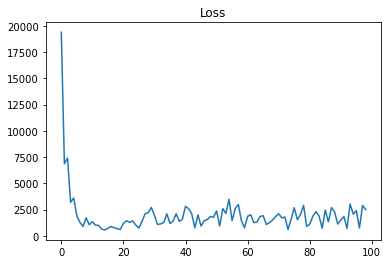

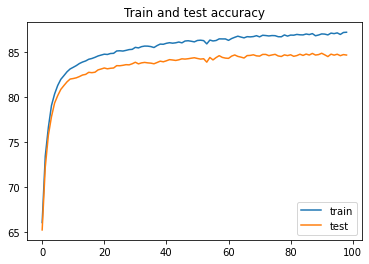

In [32]:
model = MLP_None_Hist()

optimizer = AdamMiniBatchGradientDescentHist(learning_rate=.01, max_iters=1e2, epsilon=1e-4, batch_size=10000)
model.fit(x_train, y_train, optimizer)
yh_train = model.predict(x_train)
acc_train = evaluate_acc(y_train, yh_train)
yh_test = model.predict(x_test)
acc_test = evaluate_acc(y_test, yh_test)
print(f'Training accuracy: {acc_train:.3}%.')
print(f'Test accuracy: {acc_test:.3}%.')

plt.plot(model.norm_hist)
plt.title('Loss')
plt.show()

acc_train = []
acc_test = []
for i in range (len(model.param_hist)):
    yh_train = MLP_None_Hist.check(model.param_hist[i], x_train)
    yh_test = MLP_None_Hist.check(model.param_hist[i], x_test)
    acc_train.append(evaluate_acc(yh_train, y_train))
    acc_test.append(evaluate_acc(yh_test, y_test))

plt.plot(acc_train)
plt.plot(acc_test)
plt.title('Train and test accuracy')
plt.legend(['train','test'])
plt.show()


Did not converge at maximum iteration.
norms = [2696.81160198 6724.1494352 ]
Training accuracy: 93.3%.
Test accuracy: 88.1%.


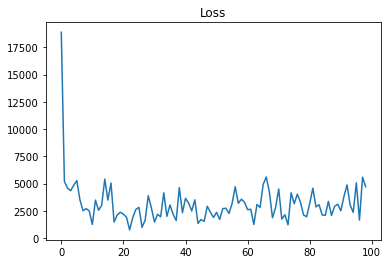

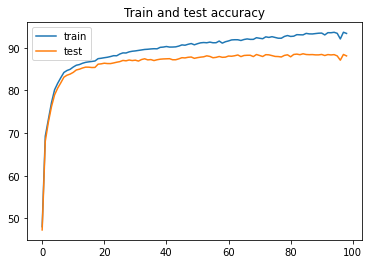

In [31]:
model = MLP_One_ReLU_Hist(M=128)

optimizer = AdamMiniBatchGradientDescentHist(learning_rate=.01, max_iters=1e2, epsilon=1e-4, batch_size=10000)
model.fit(x_train, y_train, optimizer)
yh_train = model.predict(x_train)
acc_train = evaluate_acc(y_train, yh_train)
yh_test = model.predict(x_test)
acc_test = evaluate_acc(y_test, yh_test)
print(f'Training accuracy: {acc_train:.3}%.')
print(f'Test accuracy: {acc_test:.3}%.')

plt.plot(model.norm_hist)
plt.title('Loss')
plt.show()

acc_train = []
acc_test = []
for i in range (len(model.param_hist)):
    yh_train = MLP_One_ReLU_Hist.check(model.param_hist[i], x_train)
    yh_test = MLP_One_ReLU_Hist.check(model.param_hist[i], x_test)
    acc_train.append(evaluate_acc(yh_train, y_train))
    acc_test.append(evaluate_acc(yh_test, y_test))

plt.plot(acc_train)
plt.plot(acc_test)
plt.title('Train and test accuracy')
plt.legend(['train','test'])
plt.show()


Did not converge at maximum iteration.
norms = [4779.52532072 3257.22797884 2917.35352252]
Training accuracy: 91.0%.
Test accuracy: 87.8%.


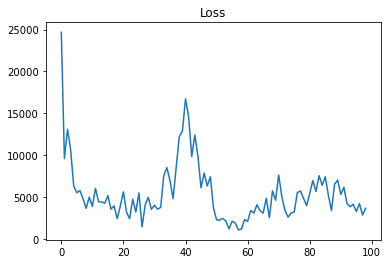

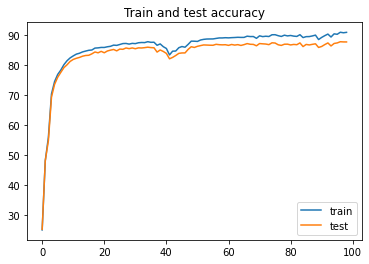

In [33]:
model = MLP_Two_ReLU_Hist(M=128,O=128)

optimizer = AdamMiniBatchGradientDescentHist(learning_rate=.01, max_iters=1e2, epsilon=1e-4, batch_size=10000)
model.fit(x_train, y_train, optimizer)
yh_train = model.predict(x_train)
acc_train = evaluate_acc(y_train, yh_train)
yh_test = model.predict(x_test)
acc_test = evaluate_acc(y_test, yh_test)
print(f'Training accuracy: {acc_train:.3}%.')
print(f'Test accuracy: {acc_test:.3}%.')

plt.plot(model.norm_hist)
plt.title('Loss')
plt.show()

acc_train = []
acc_test = []
for i in range (len(model.param_hist)):
    yh_train = MLP_Two_ReLU_Hist.check(model.param_hist[i], x_train)
    yh_test = MLP_Two_ReLU_Hist.check(model.param_hist[i], x_test)
    acc_train.append(evaluate_acc(yh_train, y_train))
    acc_test.append(evaluate_acc(yh_test, y_test))

plt.plot(acc_train)
plt.plot(acc_test)
plt.title('Train and test accuracy')
plt.legend(['train','test'])
plt.show()


## Varying the activation function

Did not converge at maximum iteration.
norms = [7508.69942453 3289.73829291 1873.29721688]
Training accuracy: 95.8%.
Test accuracy: 88.4%.


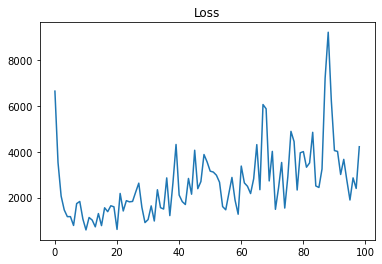

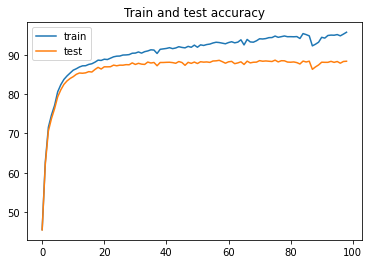

In [34]:
model = MLP_Two_tanh_Hist(M=128,O=128)

optimizer = AdamMiniBatchGradientDescentHist(learning_rate=.01, max_iters=1e2, epsilon=1e-4, batch_size=10000)
model.fit(x_train, y_train, optimizer)
yh_train = model.predict(x_train)
acc_train = evaluate_acc(y_train, yh_train)
yh_test = model.predict(x_test)
acc_test = evaluate_acc(y_test, yh_test)
print(f'Training accuracy: {acc_train:.3}%.')
print(f'Test accuracy: {acc_test:.3}%.')

plt.plot(model.norm_hist)
plt.title('Loss')
plt.show()

acc_train = []
acc_test = []
for i in range (len(model.param_hist)):
    yh_train = MLP_Two_tanh_Hist.check(model.param_hist[i], x_train)
    yh_test = MLP_Two_tanh_Hist.check(model.param_hist[i], x_test)
    acc_train.append(evaluate_acc(yh_train, y_train))
    acc_test.append(evaluate_acc(yh_test, y_test))

plt.plot(acc_train)
plt.plot(acc_test)
plt.title('Train and test accuracy')
plt.legend(['train','test'])
plt.show()


Did not converge at maximum iteration.
norms = [8233.39066246 1743.07899476 2666.98321697]
Training accuracy: 93.7%.
Test accuracy: 87.8%.


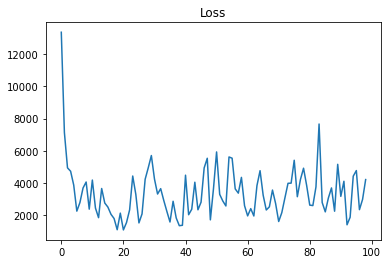

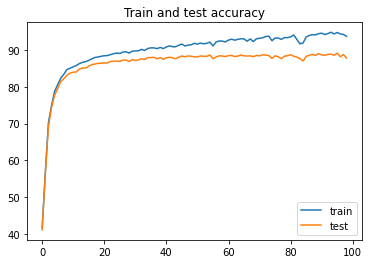

In [35]:
model = MLP_Two_leakyReLU_Hist(M=128,O=128)

optimizer = AdamMiniBatchGradientDescentHist(learning_rate=.01, max_iters=1e2, epsilon=1e-4, batch_size=10000)
model.fit(x_train, y_train, optimizer)
yh_train = model.predict(x_train)
acc_train = evaluate_acc(y_train, yh_train)
yh_test = model.predict(x_test)
acc_test = evaluate_acc(y_test, yh_test)
print(f'Training accuracy: {acc_train:.3}%.')
print(f'Test accuracy: {acc_test:.3}%.')

plt.plot(model.norm_hist)
plt.title('Loss')
plt.show()

acc_train = []
acc_test = []
for i in range (len(model.param_hist)):
    yh_train = MLP_Two_leakyReLU_Hist.check(model.param_hist[i], x_train)
    yh_test = MLP_Two_leakyReLU_Hist.check(model.param_hist[i], x_test)
    acc_train.append(evaluate_acc(yh_train, y_train))
    acc_test.append(evaluate_acc(yh_test, y_test))

plt.plot(acc_train)
plt.plot(acc_test)
plt.title('Train and test accuracy')
plt.legend(['train','test'])
plt.show()


## Adding dropout regularization

Did not converge at maximum iteration.
norms = [1979.43848566 1500.04698132 4319.91888162]
Training accuracy: 89.8%.
Test accuracy: 87.3%.


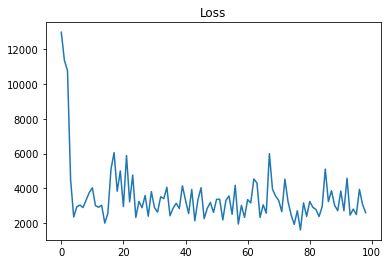

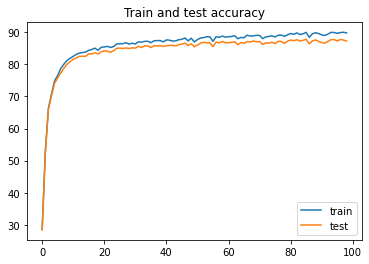

In [36]:
model = MLP_Two_ReLU_Drop_Hist(M=128,O=128,keep_rate=0.80)

optimizer = AdamMiniBatchGradientDescentHist(learning_rate=.01, max_iters=1e2, epsilon=1e-4, batch_size=10000)
model.fit(x_train, y_train, optimizer)
yh_train = model.predict(x_train)
acc_train = evaluate_acc(y_train, yh_train)
yh_test = model.predict(x_test)
acc_test = evaluate_acc(y_test, yh_test)
print(f'Training accuracy: {acc_train:.3}%.')
print(f'Test accuracy: {acc_test:.3}%.')

plt.plot(model.norm_hist)
plt.title('Loss')
plt.show()

acc_train = []
acc_test = []
for i in range (len(model.param_hist)):
    yh_train = MLP_Two_ReLU_Drop_Hist.check(model.param_hist[i], x_train)
    yh_test = MLP_Two_ReLU_Drop_Hist.check(model.param_hist[i], x_test)
    acc_train.append(evaluate_acc(yh_train, y_train))
    acc_test.append(evaluate_acc(yh_test, y_test))

plt.plot(acc_train)
plt.plot(acc_test)
plt.title('Train and test accuracy')
plt.legend(['train','test'])
plt.show()


## Using unnormalized images

Did not converge at maximum iteration.
norms = [23528.36749092  8540.02892054 12753.95336782]
Training accuracy: 94.8%.
Test accuracy: 88.6%.


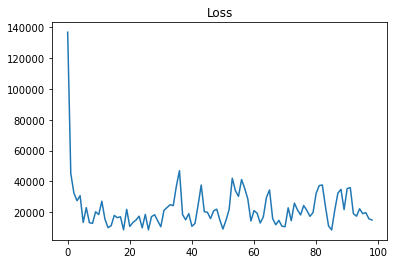

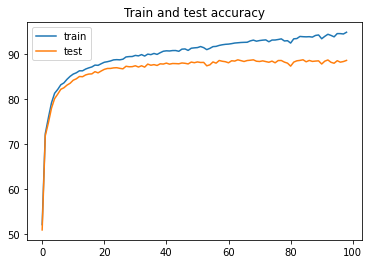

In [39]:
model = MLP_Two_ReLU_Hist(M=128,O=128)

optimizer = AdamMiniBatchGradientDescentHist(learning_rate=.001, max_iters=1e2, epsilon=1e-4, batch_size=10000)
model.fit(x_train_unnorm, y_train, optimizer)
yh_train = model.predict(x_train_unnorm)
acc_train = evaluate_acc(y_train, yh_train)
yh_test = model.predict(x_test_unnorm)
acc_test = evaluate_acc(y_test, yh_test)
print(f'Training accuracy: {acc_train:.3}%.')
print(f'Test accuracy: {acc_test:.3}%.')

plt.plot(model.norm_hist)
plt.title('Loss')
plt.show()

acc_train = []
acc_test = []
for i in range (len(model.param_hist)):
    yh_train = MLP_Two_ReLU_Hist.check(model.param_hist[i], x_train_unnorm)
    yh_test = MLP_Two_ReLU_Hist.check(model.param_hist[i], x_test_unnorm)
    acc_train.append(evaluate_acc(yh_train, y_train))
    acc_test.append(evaluate_acc(yh_test, y_test))

plt.plot(acc_train)
plt.plot(acc_test)
plt.title('Train and test accuracy')
plt.legend(['train','test'])
plt.show()


## Optimal MLP model

Did not converge at maximum iteration.
norms = [4194.35964529  826.51643215 1296.5310306 ]
Training accuracy: 95.2%.
Test accuracy: 89.3%.


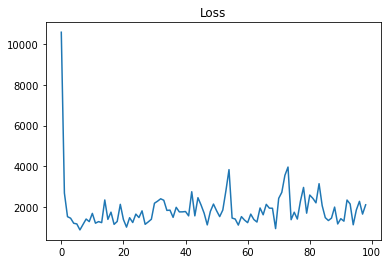

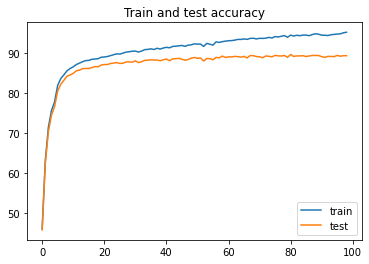

In [40]:
model = MLP_Two_tanh_Drop_Hist(M=256,O=128,keep_rate=0.75)

optimizer = AdamMiniBatchGradientDescentHist(learning_rate=.01, max_iters=1e2, epsilon=1e-4, batch_size=10000)
model.fit(x_train, y_train, optimizer)
yh_train = model.predict(x_train)
acc_train = evaluate_acc(y_train, yh_train)
yh_test = model.predict(x_test)
acc_test = evaluate_acc(y_test, yh_test)
print(f'Training accuracy: {acc_train:.3}%.')
print(f'Test accuracy: {acc_test:.3}%.')

plt.plot(model.norm_hist)
plt.title('Loss')
plt.show()

acc_train = []
acc_test = []
for i in range (len(model.param_hist)):
    yh_train = MLP_Two_tanh_Drop_Hist.check(model.param_hist[i], x_train)
    yh_test = MLP_Two_tanh_Drop_Hist.check(model.param_hist[i], x_test)
    acc_train.append(evaluate_acc(yh_train, y_train))
    acc_test.append(evaluate_acc(yh_test, y_test))

plt.plot(acc_train)
plt.plot(acc_test)
plt.title('Train and test accuracy')
plt.legend(['train','test'])
plt.show()
